In [ ]:
%pip install azure-storage-blob
%pip install opencv-python

from azure.storage.blob import BlobServiceClient
import json
import os
from PIL import Image
import matplotlib.pyplot as plt
import io  # Used to convert bytes to a file-like object
import cv2
import numpy as np


#set up storage
connection_string = "DefaultEndpointsProtocol=https;AccountName=mlfinalexam5505462853;AccountKey=0c40lghglG5/GlNK9yujDQAgo38GKoS2I3DeC/g22hwAEIFANKpmC/TqOpRk4RCT1DbfNiHBFt72+AStB+PfUA==;EndpointSuffix=core.windows.net"
container_name = "publicdata"

#create client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)
container_client = blob_service_client.get_container_client(container_name)

In [ ]:
# Variables to accumulate dimensions
total_images = 0
total_width = 0
total_height = 0

# Loop through all blobs and accumulate dimensions
blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".jpg"):
        # Download the image
        image_blob_client = container_client.get_blob_client(blob.name)
        image_content = image_blob_client.download_blob().readall()

        # Decode image with OpenCV
        image = cv2.imdecode(np.frombuffer(image_content, np.uint8), cv2.IMREAD_COLOR)

        # Accumulate dimensions
        height, width, _ = image.shape
        total_images += 1
        total_width += width
        total_height += height

# Calculate summary statistics
average_width = total_width / total_images
average_height = total_height / total_images

print(f"Total images: {total_images}")
print(f"Average width: {average_width}")
print(f"Average height: {average_height}")

In [ ]:
# Parameters for preprocessing
desired_width = 256  # Desired width for resizing
desired_height = 256  # Desired height for resizing
median_kernel_size = 5  # Kernel size for median blur
canny_threshold1 = 0.4  # Lower threshold for Canny edge detection
canny_threshold2 = 0.8  # Upper threshold for Canny edge detection

# Augmentation parameters
flip_horizontal = True
flip_vertical = True
rotate_90 = True

# Function to apply preprocessing steps
def preprocess_image(image):
    # sourcery skip: inline-immediately-returned-variable
    # Convert image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the image
    resized_image = cv2.resize(grayscale_image, (desired_width, desired_height))

    # Normalize pixel values to [0, 1]
    normalized_image = np.zeros((desired_width, desired_height), np.float32)  # Create a float32 type empty array
    cv2.normalize(resized_image, normalized_image, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(np.uint8(normalized_image * 255))

    # Apply edge detection using Canny
    #edges = cv2.Canny(np.uint8(normalized_image * 255), canny_threshold1, canny_threshold2)

    return equalized_image

# Loop through all blobs and process images directly
blobs = container_client.list_blobs()
for blob in blobs:
    if blob.name.endswith(".jpg"):
        # Download the original image
        image_blob_client = container_client.get_blob_client(blob.name)
        image_content = image_blob_client.download_blob().readall()

        # Preprocess the original image
        nparr = np.frombuffer(image_content, np.uint8)
        original_image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)  # Convert bytes to numpy array
        
        # Apply augmentations
        #augmentations = []

        # if flip_horizontal:
        #     augmentations.append(cv2.flip(original_image, 1))

        # if flip_vertical:
        #     augmentations.append(cv2.flip(original_image, 0))

        # if rotate_90:
        #     augmentations.append(cv2.rotate(original_image, cv2.ROTATE_90_CLOCKWISE))

        # Save augmented images and preprocess
        #for i, augmented_image in enumerate(augmentations):
            # Preprocess the augmented image
        #    preprocessed_image = preprocess_image(augmented_image)

        #    # Save preprocessed augmented image to a temporary file
        #    temp_file_path = f"preprocessed_augmented_image_{i}.jpg"
        #    cv2.imwrite(temp_file_path, (preprocessed_image * 255).astype(np.uint8))  # Save preprocessed image after preprocessing steps

        #    # Upload the preprocessed augmented image back to Azure Blob Storage
        #    with open(temp_file_path, "rb") as data:
        #        container_client.upload_blob(name="preprocessed/" + temp_file_path, data=data, overwrite = True)

        #    # Clean up temporary file
        #    os.remove(temp_file_path)

        # Preprocess the original image
        preprocessed_original_image = preprocess_image(original_image)

        # Save preprocessed original image to a temporary file
        original_temp_file_path = "preprocessed_original_temp_image.jpg"
        cv2.imwrite(original_temp_file_path, preprocessed_original_image)  # Save preprocessed image

        # Construct new blob path with 'preprocessed/' prefix
        preprocessed_blob_path = "preprocessed/" + blob.name

        # Upload the preprocessed original image back to Azure Blob Storage
        with open(original_temp_file_path, "rb") as data:
            container_client.upload_blob(name=preprocessed_blob_path, data=data, overwrite=True)

        # Clean up the temporary file
        os.remove(original_temp_file_path)



In [ ]:
plt.figure(figsize=(6, 6))
plt.imshow(preprocessed_original_image, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')  # Hide axes
plt.show()

In [23]:
##### Plot plain image function

# Directory where your JPEG files are located
def plot_image(image_id):
    # Get the BlobClient for the specific image
    blob_client = container_client.get_blob_client(image_id)

    # Download the blob's content as bytes
    blob_data = blob_client.download_blob().chunks()  # Read the entire blob content

    # Convert the blob data into a file-like object using io.BytesIO
    image_data = io.BytesIO(b"".join(blob_data))

    # Open the image using PIL.Image
    image = Image.open(image_data)

    # Display the image using matplotlib
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.title(f"Image with ID {image_id}")
    plt.show()




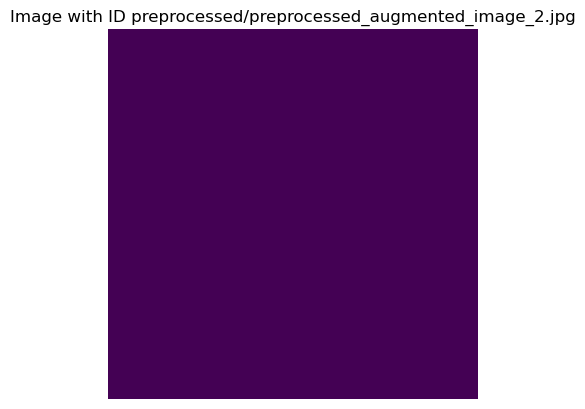

In [24]:
image = "preprocessed/preprocessed_augmented_image_2.jpg"
plot_image(image)